In [1]:
# !kaggle competitions download -c petfinder-pawpularity-score

In [2]:
import pandas as pd
from os import walk
import glob
import numpy as np
from PIL import Image 
import cv2
import re
import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import RandomSampler
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.nn import functional as F
import torch

TRAIN_PATH = './input/train'
TEST_PATH = './input/test'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu or cpu
device

e:\Dev\Anaconda\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

In [3]:
epochs = 20
lr = 1e-3
batch_size = 128

In [4]:
df_train = pd.read_csv(TRAIN_PATH+'.csv', index_col='Id')
df_train

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
Id,,,,,,,,,,,,,
0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,0,0,1,15
ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,0,0,0,70
ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,1,0,0,20


In [5]:
images = []
for f in glob.iglob(TRAIN_PATH+'/*'):
    images.append(f)



In [6]:
input_train =[]
for i in images:
    regexp_1 = re.compile(r'\./input/[^/]*[/|\\](.*)\..*')
    re_match = regexp_1.match(i)
    input_train.append((i,tuple(df_train[df_train.index == re_match.groups()[0]].iloc[0].values)))

In [7]:
transform = T.Compose([
     T.Resize((256,256)), 
     T.ToTensor(),
     T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

])

In [8]:
class CompleteDataset(Dataset):
    
    def __init__(self, imgs_list, transforms = None):
        
        super().__init__()
        self.imgs_list = imgs_list
        self.transforms = transforms
        
        
    def __getitem__(self, index):
    
        image_path = self.imgs_list[index][0]
        complentary_values = self.imgs_list[index][1][0:-1]
        popularity = self.imgs_list[index][1][-1]
        image = Image.open(image_path)
        #Reading image
        #Applying transforms on image
        if self.transforms:
            image = self.transforms(image)
        
        return image, torch.tensor(list(complentary_values)).float(),popularity
        
        
        
    def __len__(self):
        return len(self.imgs_list)

In [9]:
()

()

In [10]:
train_dataset = CompleteDataset(input_train, transform)

In [11]:
# train_random_sampler = RandomSampler(train_dataset)
train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle=True,
)

In [37]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1)
        self.relu = nn.ReLU()
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1)
        self.relu = nn.ReLU()
        self.fc_cnn_1 = nn.Linear(2032128, 16)  

        
        self.fc_linear_1 = nn.Linear(12,16)
        self.fc_linear_2 = nn.Linear(32,32)
        self.fc_linear_3 = nn.Linear(32,16)


        self.fcout = nn.Linear(32, 1)    

    def forward(self, x):
        out_cnn = self.cnn1(x[0])
        out_cnn = self.relu(out_cnn)
        out_cnn = self.cnn2(out_cnn)
        out_cnn = self.relu(out_cnn)
        out_cnn = out_cnn.view(out_cnn.size(0), -1)
        out_cnn = self.fc_cnn_1(out_cnn)


        out_cnn = self.relu(out_cnn)
        out_linear = self.fc_linear_1(x[1])
        out_linear = self.relu(out_linear)


        out = torch.cat((out_cnn, out_linear), dim=1)

        out = self.fcout(out)

        return out

In [38]:
model = Net()
model = model.to(device)
model

Net(
  (cnn1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc_cnn_1): Linear(in_features=2032128, out_features=16, bias=True)
  (fc_linear_1): Linear(in_features=12, out_features=16, bias=True)
  (fc_linear_2): Linear(in_features=32, out_features=32, bias=True)
  (fc_linear_3): Linear(in_features=32, out_features=16, bias=True)
  (fcout): Linear(in_features=32, out_features=1, bias=True)
)

In [39]:
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = nn.MSELoss()


In [41]:
train_loss = []

for epoch in range(epochs):
    current_loss = []
    
    for i, (images,comp_values, labels) in enumerate(train_data_loader):

        images = images.to(device)
        comp_values = comp_values.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()        
        preds = model([images, comp_values])
        loss = criterion(preds, labels.float())

        loss.backward()
        optimizer.step()
        current_loss.append(loss.cpu().item())
        if i % 50 == 0 :
            print(f"Iter : {i} Current mean loss : {np.sum(current_loss)/len(current_loss)}")
    mean_epoch_loss = np.sum(current_loss)/len(current_loss)
    train_loss.append(mean_epoch_loss)
    print(f'Epoch : {epoch} / {epochs} Mean loss : {mean_epoch_loss}')




KeyboardInterrupt: 

AttributeError: 'list' object has no attribute 'show'

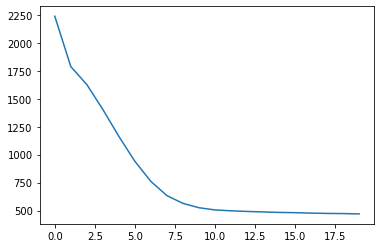

In [16]:
fig = plt.plot(train_loss)
fig.show()